In [179]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

In [ ]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

In [ ]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

In [244]:
#Value object
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None # by default does not do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # we need to accumulate those gradients
            other.grad += 1.0 * out.grad
        out._backward = _backward # we just want to store the function not to return any value

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad # chain rule for multiplication
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, exponent):
        assert isinstance(exponent, (int, float)), "only supporting int/float powers"
        out = Value(self.data**exponent, (self,), f'**{exponent}')
        
        def _backward():
            self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * (other**-1)
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # (1-t**2) is the local derivative
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # derivative is the same value (e^x) and we already have it
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # only is going to adds itself after all of its children have been listed out
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [120]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [163]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'# we have to implement tanh
o.backward()

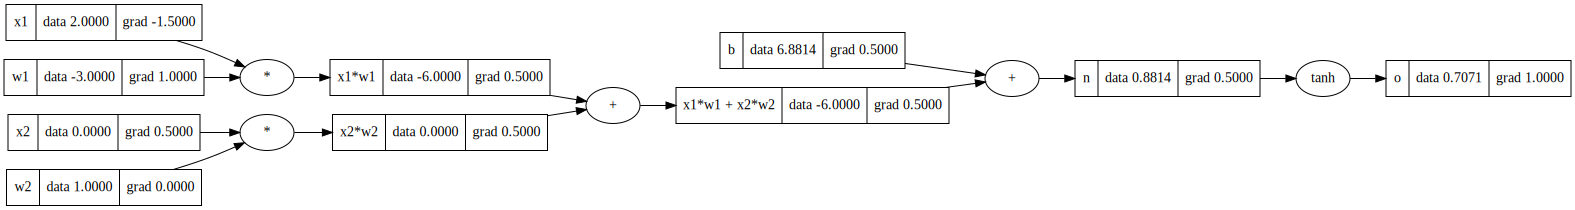

In [164]:
draw_dot(o)

In [169]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2 * n).exp(); e.label='e'
o = (e - 1) / (e + 1)
# -----
o.label = 'o'# we have to implement tanh
o.backward()

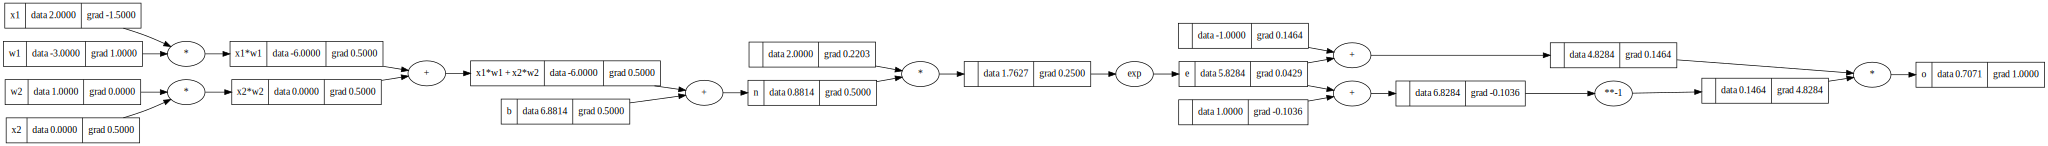

In [170]:
draw_dot(o)

In [171]:
import torch

In [172]:
# because these are leave nodes, by default pytorch assumes that they do not need gradients
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [260]:
class Neuron:
    def __init__(self, nin): # n_inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # iterator that runs on the top of all of the lists
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


Value(data=0.2854035886387655)

In [362]:
# x = [2.0, 3.0, -0.23]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7001725055579555)

In [363]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [364]:
N_epochs = 20
lr = 0.05
loss_evolution = []

for k in range(N_epochs):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # (ygt - yout) throws a TypeError: unsupported operand type(s) for -: 'float' and 'Value'
    loss_evolution.append(loss.data)
    
    # backward pass
    ## zero_grad()
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data -= lr * p.grad
    
    print(k, loss.data)

0 5.655781048432245
1 3.0153859283090707
2 1.809292983452167
3 1.037578118568161
4 0.6122755491064565
5 0.37279315917787575
6 0.27017127628006177
7 0.21001276884896988
8 0.17037909638295481
9 0.1425970949656272
10 0.12218069272314808
11 0.10661475339429723
12 0.09439403114161224
13 0.08456849090350008
14 0.0765116927048032
15 0.0697952147508764
16 0.06411688701131137
17 0.05925789856810078
18 0.05505615777144773
19 0.0513891871704444


In [365]:
ypred

[Value(data=0.9136197714888649),
 Value(data=-0.8397854757320105),
 Value(data=-0.954892730455962),
 Value(data=0.8726254195662582)]

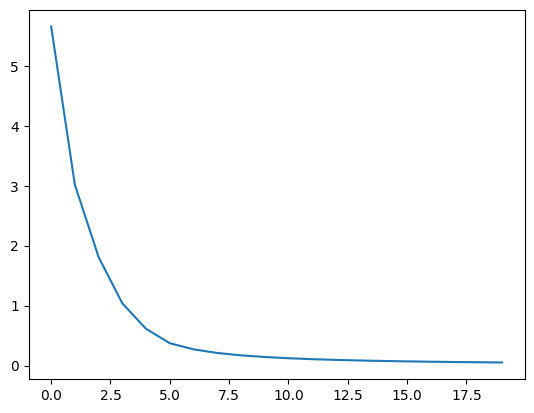

In [366]:
plt.plot(np.arange(0, N_epochs), loss_evolution)